# Fitting Kappa-HGF from Light Extinction

In the field of atmospheric science, understanding the hygroscopic growth of aerosol particles is crucial for predicting their impact on climate, weather patterns, and human health. The kappa-Hygroscopic Growth Factor (kappa-HGF) is a parameter that quantifies the ability of aerosol particles to absorb water under varying levels of relative humidity. However, kappa-HGF is not measured directly in atmospheric observations. Instead, researchers infer this parameter by analyzing changes in aerosol properties, such as light extinction, diameter growth, or light scattering, as a function of humidity.

This notebook focuses on deriving kappa-HGF from light extinction measurements at different humidity levels. Light extinction, which encompasses both scattering and absorption by aerosol particles, is a fundamental optical property that can significantly vary with particle size and composition, especially as particles undergo hygroscopic growth in humid conditions. By comparing light extinction under low and high humidity conditions, we can back-calculate kappa-HGF, offering insights into the water uptake and swelling behavior of aerosols in the atmosphere.

The methodology and analyses presented here for light extinction can be analogously applied to other aerosol properties affected by humidity changes. Understanding these dynamics is key to improving our models of aerosol-cloud interactions, radiative forcing, and visibility impairment.

**Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.util import convert, distribution_discretization
from particula.data.process import kappa_via_extinction

## Generating Synthetic Data for Kappa-HGF Analysis

To conduct a meaningful analysis of kappa-HGF (Hygroscopic Growth Factor) based on light extinction, we first need to simulate synthetic data that closely mimics atmospheric aerosol properties. This involves creating a size distribution of aerosol particles and calculating their light extinction coefficients under different humidity conditions.

### Hygroscopic Growth Parameters

For our synthetic dataset, we consider ammonium sulfate as the aerosol composition with a kappa value of 0.61. We examine the particle behavior at three distinct relative humidity (RH) levels: 30%, 60%, and 90%, representing low, mid, and high water activity scenarios, respectively.

### Size Distribution

The synthetic size distribution is modeled as a bimodal log-normal distribution, capturing the diversity in particle sizes typically observed in atmospheric aerosols. The distribution spans from 20 nm to 1000 nm with 500 discrete points, encompassing a wide range of aerosol sizes. The distribution is characterized by two modes at 100 nm and 500 nm and a geometric standard deviation of 1.25, simulating a realistic atmospheric aerosol size distribution.

#### Calculation Steps

1. **Volume Conversion**: Convert the diameters from the base distribution to volumes, facilitating the subsequent calculation of water volume absorbed by the particles at different RH levels.
   
2. **Water Volume Calculation**: For each RH level, calculate the volume of water absorbed by the particles, leveraging the kappa value to simulate hygroscopic growth.

3. **Diameter Adjustment**: Adjust the particle diameters based on the absorbed water volume to obtain new diameters that reflect hygroscopic growth at each RH level.

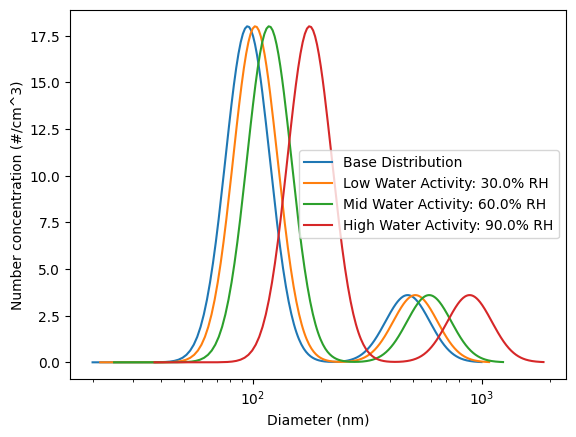

In [3]:
# Hygroscopic growth parameters
kappa = 0.61  # Kappa value for ammonium sulfate
water_activity_low = 0.3  # Low water activity (30% RH)
water_activity_mid = 0.6  # Mid water activity (60% RH)
water_activity_high = 0.9  # High water activity (90% RH)

# Define the range and resolution of particle diameters (in nanometers)
diameters = np.linspace(20, 1000, 500)  # From 20 nm to 1000 nm with 500 points

# Standard deviation of the log-normal distribution (dimensionless)
sigma = 1.25

# Define the modes (peak diameters) for a bimodal distribution
modes = [100, 500]

# Total number of particles in the distribution
number_total = 1e3

# Generate a log-normal probability density function (pdf) with an area
# equal to 1
pdf_dist = distribution_discretization.discretize(
    interval=diameters,  # Array of diameters over which to compute the distribution
    disttype="lognormal",  # Type of distribution
    gsigma=sigma,  # Geometric standard deviation
    mode=modes,  # Modes of the distribution
    nparticles=number_total  # Total number of particles
).m

# Convert the distribution from pdf to probability mass function (pmf)
number_conc_pms = convert.distribution_convert_pdf_pms(
    x_array=diameters,  # Array of diameters
    distribution=pdf_dist,  # The generated pdf
    to_pdf=False  # Specifies the conversion to pmf
) * number_total  # Scale to the total number of particles


# Convert particle diameters from the base distribution to volumes
volume_sizer = convert.length_to_volume(diameters, length_type='diameter')

# Calculate water volume absorbed by particles at different RH
volume_water_low = convert.kappa_volume_water(
    volume_solute=volume_sizer,
    kappa=kappa,
    water_activity=water_activity_low)  # showing the input parameters
volume_water_mid = convert.kappa_volume_water(
    volume_sizer, kappa, water_activity_mid)
volume_water_high = convert.kappa_volume_water(
    volume_sizer, kappa, water_activity_high)

# Calculate new particle diameters after hygroscopic growth
diameters_low = convert.volume_to_length(
    volume=volume_sizer + volume_water_low,
    length_type='diameter')  # showing the input parameters
diameters_mid = convert.volume_to_length(
    volume_sizer + volume_water_mid, 'diameter')
diameters_high = convert.volume_to_length(
    volume_sizer + volume_water_high, 'diameter')

# Plotting the base and grown size distributions
fig, ax = plt.subplots()
ax.plot(diameters, number_conc_pms, label="Base Distribution")
ax.plot(
    diameters_low,
    number_conc_pms,
    label=f"Low Water Activity: {water_activity_low*100}% RH")
ax.plot(
    diameters_mid,
    number_conc_pms,
    label=f"Mid Water Activity: {water_activity_mid*100}% RH")
ax.plot(
    diameters_high,
    number_conc_pms,
    label=f"High Water Activity: {water_activity_high*100}% RH")
ax.set_xscale("log")
ax.set_xlabel("Diameter (nm)")
ax.set_ylabel("Number concentration (#/cm^3)")
ax.legend()
plt.show()

## Simulating Light Extinction for Hygroscopic Growth

After generating synthetic aerosol distributions and analyzing their hygroscopic growth, the next crucial step is to simulate how these changes affect the aerosols' light extinction properties at different humidity levels. Light extinction, a key optical property, combines the effects of both scattering and absorption by particles, and varies significantly with particle size, composition, and ambient humidity. In this section, we calculate the extinction coefficients for our simulated aerosol distributions at low, mid, and high relative humidity (RH) conditions.

To simulate the extinction at each specified humidity, we employ the `extinction_ratio_wet_dry` function from the `kappa_via_extinction` module. This function calculates the extinction coefficients by considering the hygroscopic growth of particles and their resulting optical properties.

*Note*: The size distribution hygroscopic growth and refractive index mixing are handled internally by the `extinction_ratio_wet_dry` function, so we only need to provide the base size distribution and the RH levels of interest.


In [11]:
# Define the kappa value and refractive index for dry particles
kappa = 0.61  # Kappa value for ammonium sulfate
refractive_index_dry = 1.45  # Refractive index of dry particles

# Define the wavelength of light for extinction calculations
wavelength = 450  # Wavelength in nanometers

# Calculate extinction coefficients at different humidities
ext_low, ext_base = kappa_via_extinction.extinction_ratio_wet_dry(
    kappa=kappa,
    number_per_cm3=number_conc_pms,
    diameters=diameters,
    water_activity_sizer=0.0,  # Base condition for sizer water activity
    water_activity_dry=0.0,    # Dry condition water activity
    water_activity_wet=water_activity_low,  # Low RH condition
    refractive_index_dry=refractive_index_dry,
    wavelength=wavelength,
    discretize=True,
    return_coefficients=True,
    return_all_optics=False
)
ext_mid, _ = kappa_via_extinction.extinction_ratio_wet_dry(
    kappa=kappa,
    number_per_cm3=number_conc_pms,
    diameters=diameters,
    water_activity_sizer=0.0,
    water_activity_dry=0.0,
    water_activity_wet=water_activity_mid,
    refractive_index_dry=refractive_index_dry,
    wavelength=wavelength,
    discretize=True,
    return_coefficients=True,
    return_all_optics=False,
)
ext_high, _ = kappa_via_extinction.extinction_ratio_wet_dry(
    kappa=kappa,
    number_per_cm3=number_conc_pms,
    diameters=diameters,
    water_activity_sizer=0.0,
    water_activity_dry=0.0,
    water_activity_wet=water_activity_high,
    refractive_index_dry=refractive_index_dry,
    wavelength=wavelength,
    discretize=True,
    return_coefficients=True,
    return_all_optics=False,
)

# print all extinctions
print(f"Extinction at 0.0% RH: {ext_base}")
print(f"Extinction at {water_activity_low*100}% RH: {ext_low}")
print(f"Extinction at {water_activity_mid*100}% RH: {ext_mid}")
print(f"Extinction at {water_activity_high*100}% RH: {ext_high}")

Extinction at 0.0% RH: 389.78121694944446
Extinction at 30.0% RH: 455.3096828541398
Extinction at 60.0% RH: 606.9502182185444
Extinction at 90.0% RH: 1242.6228046612712


## Fitting Kappa-HGF to Dry Aerosol Data

After generating synthetic aerosol distributions and simulating their light extinction at various humidity levels, we proceed to fit the kappa-Hygroscopic Growth Factor (kappa-HGF) to our synthetic data. This process involves using the extinction data previously calculated to infer the kappa-HGF values that best describe the observed changes in light extinction due to hygroscopic growth.

To achieve this, we employ the `fit_extinction_ratio_with_kappa` function from the `kappa_via_extinction` module. This function optimizes the kappa value to match the simulated wet-to-dry extinction ratio, providing a quantitative measure of the particles' hygroscopicity. The fitting is performed for low, mid, and high humidity conditions, allowing us to observe how kappa-HGF varies with relative humidity (RH) of the measurement environment. It should be relatively close to the kappa value used in the synthetic data generation (0.61).

This code snippet demonstrates the process of fitting kappa-HGF to the synthetic data, highlighting the kappa values obtained for different RH conditions. The fitting process is crucial for translating the wet-to-dry extinction ratios into a meaningful measure of particle hygroscopicity, which can then be used to improve our understanding of aerosol behavior in the atmosphere.

In [17]:
fit_low = kappa_via_extinction.fit_extinction_ratio_with_kappa(
    b_ext_dry=ext_base,
    b_ext_wet=ext_low,
    number_per_cm3=number_conc_pms,
    diameters=diameters,
    water_activity_sizer=0.0,
    water_activity_dry=0.0,
    water_activity_wet=water_activity_low,
    refractive_index_dry=refractive_index_dry,
    wavelength=wavelength,
    discretize=True,
    kappa_bounds=(0, 1),
    kappa_tolerance= 1e-12,
    kappa_maxiter=200,
)
fit_mid = kappa_via_extinction.fit_extinction_ratio_with_kappa(
    b_ext_dry=ext_base,
    b_ext_wet=ext_mid,
    number_per_cm3=number_conc_pms,
    diameters=diameters,
    water_activity_sizer=0.0,
    water_activity_dry=0.0,
    water_activity_wet=water_activity_mid,
    refractive_index_dry=refractive_index_dry,
    wavelength=wavelength,
    discretize=True,
    kappa_bounds=(0, 1),
    kappa_tolerance= 1e-12,
    kappa_maxiter=200,
)
fit_high = kappa_via_extinction.fit_extinction_ratio_with_kappa(
    b_ext_dry=ext_base,
    b_ext_wet=ext_high,
    number_per_cm3=number_conc_pms,
    diameters=diameters,
    water_activity_sizer=0.0,
    water_activity_dry=0.0,
    water_activity_wet=water_activity_high,
    refractive_index_dry=refractive_index_dry,
    wavelength=wavelength,
    discretize=True,
    kappa_bounds=(0, 1),
    kappa_tolerance= 1e-12,
    kappa_maxiter=200,
)

# print all fits

print(f"Kappa at {water_activity_low*100}% RH: {fit_low}")
print(f"Kappa at {water_activity_mid*100}% RH: {fit_mid}")
print(f"Kappa at {water_activity_high*100}% RH: {fit_high}")

Kappa at 30.0% RH: 0.6052222023205297
Kappa at 60.0% RH: 0.610000003943248
Kappa at 90.0% RH: 0.610062704938107


## Insensitivity to Humidity in Sizer and Extinction Measurements

In the complex world of atmospheric measurements, not all data are perfect. One of the challenges is dealing with the humidity effects on both the size distribution measurements and the extinction coefficients for dry and wet aerosol particles. This section demonstrates that by carefully accounting for humidity in these measurements, the fitted kappa-Hygroscopic Growth Factor (kappa-HGF) remains robust and insensitive to variations in the size distribution caused by humidity. This resilience is particularly crucial when dealing with ambient measurements, where the assumption of perfectly dry particles may not hold.

### Fitting Kappa-HGF under Varied Humidity Conditions

To illustrate this point, we perform kappa-HGF fitting under conditions where the sizer humidity is not zero, simulating more realistic scenarios where dry particles may still retain some moisture. We explore how kappa-HGF responds to changes in the humidity of the sizer used to measure the size distribution and the humidity conditions under which dry and wet extinction coefficients are obtained.

### Key Insights

The kappa-HGF fitting outcomes demonstrate that the approach remains effective even when the sizer's humidity and the conditions for measuring dry and wet extinctions incorporate realistic humidity levels. This robustness ensures that kappa-HGF can be accurately determined from ambient aerosol measurements, accommodating the inherent moisture that may be present in "dry" aerosol samples.

Understanding and adjusting for these nuances in humidity is essential for accurately characterizing aerosol optical properties and their environmental impacts. By acknowledging and accounting for these factors in our analysis, we enhance the reliability of kappa-HGF estimations, paving the way for more accurate atmospheric models and predictions.

In [19]:
# Perform kappa-HGF fitting with a humid sizer at mid RH
fit_humid_sizer_mid = kappa_via_extinction.fit_extinction_ratio_with_kappa(
    b_ext_dry=ext_base,
    b_ext_wet=ext_mid,
    number_per_cm3=number_conc_pms,
    diameters=diameters_mid,
    water_activity_sizer=water_activity_mid,  # Sizer humidity set to mid RH
    water_activity_dry=0.0,  # Dry condition
    water_activity_wet=water_activity_mid,  # Wet condition matches sizer RH
    refractive_index_dry=refractive_index_dry,
    wavelength=wavelength,
    discretize=True,
    kappa_bounds=(0, 1),
    kappa_tolerance=1e-12,
    kappa_maxiter=200
)

# Repeat fitting with humid sizer at mid RH and extinction measurements at
# low and high RH
fit_humid_sizer_mid_and_humid_ext_low = kappa_via_extinction.fit_extinction_ratio_with_kappa(
    b_ext_dry=ext_low,  # Dry extinction at low RH
    b_ext_wet=ext_high,  # Wet extinction at high RH
    number_per_cm3=number_conc_pms,
    diameters=diameters_mid,  # Diameters adjusted for mid RH
    water_activity_sizer=water_activity_mid,  # Mid RH for sizer
    water_activity_dry=water_activity_low,  # Low RH for dry condition
    water_activity_wet=water_activity_high,  # High RH for wet condition
    refractive_index_dry=refractive_index_dry,
    wavelength=wavelength,
    discretize=True,
    kappa_bounds=(0, 1),
    kappa_tolerance=1e-12,
    kappa_maxiter=200
)

# Print the fitted kappa values
print(
    f"Kappa from humid sizer at {water_activity_mid*100}% RH and dry Ext: {fit_humid_sizer_mid}")
print(f"Kappa from humid sizer at {water_activity_mid*100}% RH and humid Ext from {water_activity_low*100}% RH to {water_activity_high*100}% RH: {fit_humid_sizer_mid_and_humid_ext_low}")

Kappa 0.6100000005341284 from humid sizer 60.0% RH and dry Ext: 
Kappa 0.6099999998804534 from humid sizer 60.0% RH and humid Ext 30.0% RH: 


## Examining the Impact of Dry Refractive Index on Kappa-HGF Estimation

The refractive index of aerosol particles plays a pivotal role in determining their optical properties, such as light extinction. When deducing the kappa-Hygroscopic Growth Factor (kappa-HGF) from light extinction data, the choice of the dry aerosol particle's refractive index can significantly influence the precision of the resulting kappa estimation. This exploration delves into the sensitivity of the kappa-HGF fitting process to variations in the assumed dry refractive index, underscoring the necessity of accurately selecting this parameter for reliable hygroscopicity assessments.

Initially, we assumed a dry refractive index of \(1.45 + 0i\) for generating extinction data. Here, we venture into how alterations in this assumed refractive index affect the kappa-HGF fitting outcomes. Specifically, we examine the response of the kappa-HGF fitting to both modest deviations and more pronounced shifts from the initially assumed value, including both lower and higher indices, to ascertain the robustness of kappa estimation against such variations.

In [30]:
# Fitting kappa-HGF with varied assumptions on the dry refractive index
fit_refractive_index_lower = kappa_via_extinction.fit_extinction_ratio_with_kappa(
    b_ext_dry=ext_base,
    b_ext_wet=ext_mid,
    number_per_cm3=number_conc_pms,
    diameters=diameters,
    water_activity_sizer=0.0,
    water_activity_dry=0.0,
    water_activity_wet=water_activity_mid,
    refractive_index_dry=1.4,  # Assumption of a lower refractive index
    wavelength=wavelength,
    kappa_bounds=(0, 1),
    kappa_tolerance=1e-12,
    kappa_maxiter=200
)

fit_refractive_index_higher = kappa_via_extinction.fit_extinction_ratio_with_kappa(
    b_ext_dry=ext_base,
    b_ext_wet=ext_mid,
    number_per_cm3=number_conc_pms,
    diameters=diameters,
    water_activity_sizer=0.0,
    water_activity_dry=0.0,
    water_activity_wet=water_activity_mid,
    refractive_index_dry=1.55,  # Assumption of a higher refractive index
    wavelength=wavelength,
    kappa_bounds=(0, 1),
    kappa_tolerance=1e-12,
    kappa_maxiter=200
)

fit_refractive_index_close = kappa_via_extinction.fit_extinction_ratio_with_kappa(
    b_ext_dry=ext_base,
    b_ext_wet=ext_mid,
    number_per_cm3=number_conc_pms,
    diameters=diameters,
    water_activity_sizer=0.0,
    water_activity_dry=0.0,
    water_activity_wet=water_activity_mid,
    refractive_index_dry=1.48,  # A close but distinct refractive index
    wavelength=wavelength,
    kappa_bounds=(0, 1),
    kappa_tolerance=1e-12,
    kappa_maxiter=200
)

# Output the fitted kappa values for each refractive index assumption
print(f"Kappa from lower refractive index 1.4: {fit_refractive_index_lower}")
print(
    f"Kappa from higher refractive index 1.55: {fit_refractive_index_higher}")
print(f"Kappa from close refractive index 1.48: {fit_refractive_index_close}")

Kappa from lower refractive index 1.4: 0.5112947684591423
Kappa from higher refractive index 1.55: 0.7043352860513862
Kappa from close refractive index 1.48: 0.6563062276765905


## Robustness of Kappa-HGF Estimation Against Particle Number Variations

A noteworthy aspect of estimating the kappa-Hygroscopic Growth Factor (kappa-HGF) from light extinction measurements is its robustness to variations in the total number of aerosol particles. This resilience is attributed to the optimization process focusing on the extinction ratio rather than absolute extinction values. Consequently, discrepancies in the total particle number do not significantly affect the kappa-HGF fitting outcomes. This section demonstrates this principle by applying kappa-HGF fitting to synthetic datasets with deliberately altered particle number concentrations.

### Demonstrating Insensitivity through Particle Number Variation

The experiment involves adjusting the particle number concentration to 20% of its original value in the synthetic dataset. Despite this substantial reduction, we observe that the kappa-HGF estimation process yields consistent results, underscoring the fitting technique's insensitivity to the absolute particle count within the aerosol distribution. This characteristic is particularly advantageous when dealing with ambient measurements, where precise particle counting may be challenging.

### Implications for Ambient Aerosol Measurements

The findings from this sensitivity analysis have implications for conducting ambient aerosol measurements and analyses. They highlight the fitting process's adaptability and accuracy, even when the exact particle count is uncertain or varies across measurements. As long as the relative distribution of particle sizes remains representative of the aerosol population under study, kappa-HGF estimates can be reliably derived, facilitating accurate assessments of aerosol hygroscopicity and its atmospheric impacts.

In [32]:
fit_low_number = kappa_via_extinction.fit_extinction_ratio_with_kappa(
    b_ext_dry=ext_base,
    b_ext_wet=ext_high,
    number_per_cm3=number_conc_pms*0.2,  # 20% of the base number concentration
    diameters=diameters,
    water_activity_sizer=0.0,
    water_activity_dry=0.0,
    water_activity_wet=water_activity_high,
    refractive_index_dry=refractive_index_dry,
    wavelength=wavelength,
    discretize=True,
    kappa_bounds=(0, 1),
    kappa_tolerance=1e-12,
    kappa_maxiter=200,
)
# print result
print(f"Kappa at {water_activity_high*100}% RH with 20% of the particles: {fit_low_number}")

Kappa at 90.0% RH with 20% of the particles: 0.6100627049381072


## Summary of Kappa-HGF Fitting Notebook

This notebook delves into the intricacies of fitting the kappa-Hygroscopic Growth Factor (kappa-HGF) using synthetic aerosol data. The kappa-HGF is an essential parameter in atmospheric sciences, quantifying the water-absorbing capabilities of aerosol particles and their influence on cloud formation and climate. The notebook methodically guides through generating synthetic aerosol size distributions, simulating their light extinction under various humidity conditions, and employing these simulations to estimate kappa-HGF. Key highlights include:

### Synthetic Data Generation

- **Aerosol Size Distribution**: We created synthetic bimodal log-normal size distributions, representing atmospheric aerosol populations. This step is crucial for simulating realistic aerosol behaviors under varying environmental conditions.
- **Hygroscopic Growth Simulation**: By adjusting the size distribution for different relative humidity levels, we simulated the hygroscopic growth of aerosols, providing a foundation for subsequent extinction calculations.
- **Extinction Coefficients**: We calculated light extinction coefficients for the synthetic aerosol distributions at low, mid, and high humidity levels. 

### Kappa-HGF Fitting

- **Insensitivity to Humidity in Measurements**: Demonstrating the fitting process's robustness, we showed that kappa-HGF estimation is insensitive to variations in humidity during size distribution measurements, ensuring reliable kappa estimations from ambient aerosol data.
- **Sensitivity to Dry Refractive Index**: Exploring the impact of the assumed dry refractive index on kappa-HGF fitting revealed the importance of accurately selecting this parameter for precise hygroscopicity assessments.
- **Insensitivity Against Particle Number**: The kappa-HGF fitting process proved to be resilient to changes in the total number of aerosol particles, emphasizing the method's suitability for ambient aerosol studies where particle counts may fluctuate.

### Conclusions and Implications

The notebook's findings underscore the efficacy and reliability of the kappa-HGF fitting process, even under the inherent variability and uncertainties of atmospheric aerosol measurements. By accurately estimating kappa-HGF from light extinction data, scientists can better understand aerosol hygroscopic growth, improving models of aerosol-cloud interactions and assessing aerosols' environmental and climatic impacts. This work highlights the critical role of precise parameter selection and the robustness of the kappa-HGF estimation process, contributing valuable insights to the field of atmospheric sciences.

In [33]:
help(kappa_via_extinction.extinction_ratio_wet_dry)

Help on function extinction_ratio_wet_dry in module particula.data.process.kappa_via_extinction:

extinction_ratio_wet_dry(kappa: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], number_per_cm3: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], diameters: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], water_activity_sizer: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], water_activity_dry: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], water_activity_wet: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], refractive_index_dry: Union[complex, float] = 1.45, water_refractive_index: Union[complex, float] = 1.33, wavelength: float = 450, discretize: bool = True, return_coefficients: bool = False, return_all_optics: bool = False) -> Union[float, Tuple[numpy.ndarray[Any, numpy.dtype[+_ScalarType_co]], numpy.ndarray[Any, numpy.dtype[+_ScalarType_co]]]]
    Calculates the extinction ratio between wet and dry aerosols, considering
    water uptake th

In [34]:
help(kappa_via_extinction.fit_extinction_ratio_with_kappa)

Help on function fit_extinction_ratio_with_kappa in module particula.data.process.kappa_via_extinction:

fit_extinction_ratio_with_kappa(b_ext_dry: Union[float, numpy.float64], b_ext_wet: Union[float, numpy.float64], number_per_cm3: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], diameters: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], water_activity_sizer: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], water_activity_dry: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], water_activity_wet: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], refractive_index_dry: Union[complex, float] = 1.45, water_refractive_index: Union[complex, float] = 1.33, wavelength: float = 450, discretize: bool = True, kappa_bounds: Tuple[float, float] = (0, 1), kappa_tolerance: float = 1e-06, kappa_maxiter: int = 100) -> Union[float, numpy.float64]
    Fits the kappa parameter based on the measured extinction ratios of dry
    and wet aerosols, utilizing Mie theory to account 

In [37]:
help(kappa_via_extinction.kappa_from_extinction_looped)

Help on function kappa_from_extinction_looped in module particula.data.process.kappa_via_extinction:

kappa_from_extinction_looped(extinction_dry: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], extinction_wet: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], number_per_cm3: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], diameter: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], water_activity_sizer: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], water_activity_sample_dry: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], water_activity_sample_wet: numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]], refractive_index_dry: Union[complex, float] = 1.45, water_refractive_index: Union[complex, float] = 1.33, wavelength: float = 450, discretize: bool = True) -> numpy.ndarray[typing.Any, numpy.dtype[numpy.float64]]
    Fits the extinction ratio to the kappa value for a given set of
    measurements, looping over time indexes in number_per_cm3. This f